Using device: cuda


/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:1535: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 1/5 - Loss: 0.2372
Epoch 2/5 - Loss: 0.0971
Epoch 3/5 - Loss: 0.0739
Epoch 4/5 - Loss: 0.0622
Epoch 5/5 - Loss: 0.0511

Test Accuracy: 99.10%


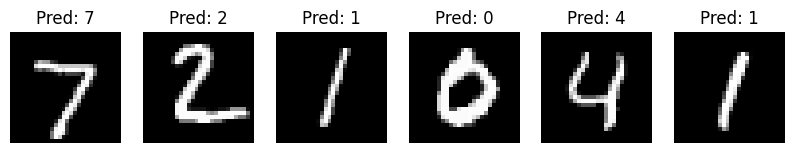

In [2]:
# ================================================================
# Handwritten Digit Classifier using PyTorch (MNIST Dataset)
# ================================================================

# =========================
# 1. Imports & Setup
# =========================
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Check device (GPU/CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# =========================
# 2. Data Loading & Preprocessing
# =========================
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))   # normalize to [-1, 1]
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset  = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# =========================
# 3. Define the CNN Model
# =========================
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

model = CNN().to(device)

# =========================
# 4. Define Loss & Optimizer
# =========================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# =========================
# 5. Training Loop
# =========================
epochs = 5
for epoch in range(1, epochs+1):
    model.train()
    running_loss = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch}/{epochs} - Loss: {running_loss/len(train_loader):.4f}")

# =========================
# 6. Evaluation on Test Data
# =========================
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

accuracy = 100 * correct / total
print(f"\nTest Accuracy: {accuracy:.2f}%")

# =========================
# 7. Visualize Predictions
# =========================
examples = iter(test_loader)
images, labels = next(examples)
images, labels = images[:6].to(device), labels[:6].to(device)
output = model(images)
preds = output.argmax(dim=1, keepdim=True)

plt.figure(figsize=(10,3))
for i in range(6):
    plt.subplot(1,6,i+1)
    plt.imshow(images[i].cpu().squeeze(), cmap="gray")
    plt.title(f"Pred: {preds[i].item()}")
    plt.axis("off")
plt.show()
